In [1]:
import gc
from time import time, sleep

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models.segmentation as models

from semantic_segmentation.dataset import CustomDataset, ToTensorNormalize
from stats import discord_bot

Successfully loaded webhook and imgbb api
Loaded API:
Discord Webhook: ***REMOVED***
ImgBB: ***REMOVED***


In [2]:
from scipy.signal import lfilter
def smooth(arr: np.ndarray, weight: float) -> np.ndarray:
    return lfilter([1. - weight], [1., -weight], arr, zi=[arr[0]])[0]

In [3]:
def calculate_iou(pred, target, num_classes):
    ious = []
    if len(pred.shape) == 4:
        pred = torch.argmax(pred, dim=1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

In [4]:
data = torch.load("./models/SSDataset.pt")

In [14]:
is_recording = "./semantic_segmentation/resnet101/ss_resnet101_16.pt"
torch.manual_seed(2050808)
current_epoch = 0

# model_type = "mobile"
# num_epochs = 100
# num_steps_end_decay = 30
# batch_size = 32
# lr_start = 1e-3
# lr_gamma = 0.999978

model_type = "res101"
num_epochs = 20
num_steps_end_decay = 10
batch_size = 32
lr_start = 1e-3
lr_gamma = 0.9999669

(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

device(type='cuda')

In [6]:
model_cls, model_weight, mobile_name, tqdm_miniters = {
    "mobile"    : (models.deeplabv3_mobilenet_v3_large, 
                   models.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT,
                   "DeepLabV3-MobileNet", 20),
    "res101"    : (models.deeplabv3_resnet101, 
                   models.DeepLabV3_ResNet101_Weights.DEFAULT,
                   "DeepLabV3-ResNet101", 5)
}[model_type]

In [7]:
model = model_cls(weights=model_weight)
prev = model.classifier[-1]
model.classifier[-1] = nn.Conv2d(prev.in_channels, 13, kernel_size=prev.kernel_size, stride=prev.stride)
del prev
gc.collect();

In [29]:
import torch
import numpy as np
x = np.zeros((3, 3), dtype=np.uint8)
y = torch.ones((3, 2), dtype=torch.long).cuda()

In [30]:
x[:, :2] = y
x

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [8]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr_start)
optimizer.param_groups[0]["initial_lr"] = lr_start
# scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-4, end_factor=1e-5, total_iters=num_steps_end_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma, last_epoch=current_epoch-1) if num_steps_end_decay else None

In [9]:
webhook = discord_bot(extra=f"{mobile_name}(lr={lr_start}; {lr_gamma if num_steps_end_decay else ''}; {num_steps_end_decay})")

In [10]:
# Create dataset and data loader
dataset = CustomDataset(data=data, transform=ToTensorNormalize(device=device))
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
(eval_frequency := ((train_size // batch_size) + bool(train_size % batch_size)) // 5)

1389

In [25]:
is_recording = "semantic_segmentation/resnet101/ss_resnet101_18.pt"
if is_recording:
    checkpoint = torch.load(is_recording)
    model.load_state_dict(checkpoint["model"])
    model.eval()
    test_range = int((2*60+18)*35/4)*10
    gif_dataset = CustomDataset(data=data[:test_range, :, :, :], transform=ToTensorNormalize(device=device))
    gif_loader = DataLoader(gif_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    predictions = []
    iou_scores = []
    with torch.no_grad():
        for test_images, test_masks in tqdm(gif_loader, desc="Inferencing", leave=True):
            pred = torch.argmax(model(test_images)['out'], dim=1)
            iou = calculate_iou(pred, test_masks, num_classes=13)
            iou_scores.append(iou)
            pred *= 20
            predictions.append(pred.cpu().numpy())

    # prediction_concat = np.concatenate(predictions, axis=0)

    # from PIL import Image
    # from matplotlib.pyplot import cm

    # cmap = cm.jet
    # frames = []
    # scale = 0

    # data_subset = data[:test_range, :, :, :].cpu().numpy()

    # for i in trange(test_range, miniters=50, desc="Creating Gif", leave=True):
    #     mapped = np.array(cmap(data_subset[i, 3, :, :])[:, :, :3] * 255, dtype=np.uint8)
    #     predicted = np.array(cmap(prediction_concat[i, :, :])[:, :, :3] * 255, dtype=np.uint8)
    #     img = np.concatenate([data_subset[i, :3, :, :].transpose(1, 2, 0), mapped, predicted])
    #     if scale:
    #         img = np.repeat(np.repeat(img, repeats=scale, axis=0), repeats=scale, axis=1)
    #     frames.append(Image.fromarray(img))

    # frames[0].save(f"test_resnet101.gif", save_all = True, append_images=frames[1:], optimize=True, duration=4000/35)
    print(f"MIoU: {np.mean(iou_scores):.4f}")

Inferencing:   0%|          | 0/378 [00:00<?, ?it/s]

MIoU: 0.7651


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Initial MIoU: 0.0059


Epoch 0:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 1, Batch 1389, Mean IoU: 0.5837 (0.5894), Training Loss: 0.08188252
LR: 0.00095506, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 1, Batch 2778, Mean IoU: 0.7030 (0.7060), Training Loss: 0.06032843
LR: 0.00091215, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 1, Batch 4167, Mean IoU: 0.0648 (0.0599), Training Loss: 0.05215479
LR: 0.00087116, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 1, Batch 5556, Mean IoU: 0.7175 (0.7197), Training Loss: 0.04699905
LR: 0.00083201, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 1, Batch 6945, Mean IoU: 0.7254 (0.7273), Training Loss: 0.04342272
LR: 0.00079463, Eval time:  2 min  8 sec


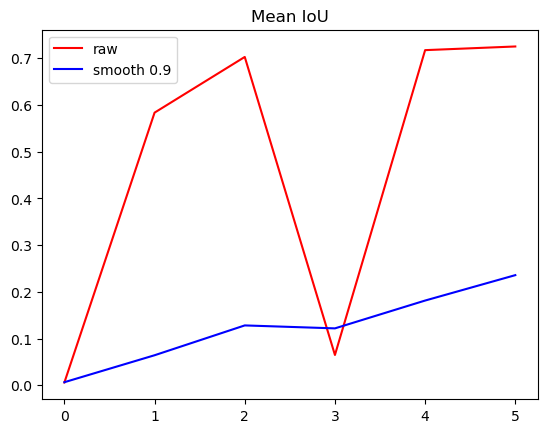

Epoch 1/20, Training Loss: 0.0434, Training Time:   1 hr  7 min 29 sec


Epoch 1:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 2, Batch 1389, Mean IoU: 0.7212 (0.7237), Training Loss: 0.02737962
LR: 0.00075882, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 2, Batch 2778, Mean IoU: 0.6679 (0.6737), Training Loss: 0.02731079
LR: 0.00072472, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 2, Batch 4167, Mean IoU: 0.7426 (0.7460), Training Loss: 0.02701658
LR: 0.00069215, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 2, Batch 5556, Mean IoU: 0.7510 (0.7541), Training Loss: 0.02646506
LR: 0.00066105, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 2, Batch 6945, Mean IoU: 0.7531 (0.7585), Training Loss: 0.02606786
LR: 0.00063135, Eval time:  2 min  8 sec


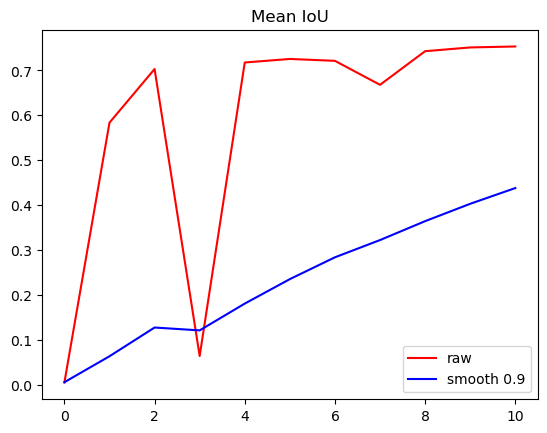

Epoch 2/20, Training Loss: 0.0261, Training Time:   2 hr 13 min  7 sec


Epoch 2:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 3, Batch 1389, Mean IoU: 0.7461 (0.7517), Training Loss: 0.02435899
LR: 0.00060290, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 3, Batch 2778, Mean IoU: 0.7613 (0.7657), Training Loss: 0.02390767
LR: 0.00057581, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 3, Batch 4167, Mean IoU: 0.7651 (0.7699), Training Loss: 0.02349017
LR: 0.00054993, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 3, Batch 5556, Mean IoU: 0.7659 (0.7696), Training Loss: 0.02335100
LR: 0.00052522, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 3, Batch 6945, Mean IoU: 0.7660 (0.7698), Training Loss: 0.02305336
LR: 0.00050162, Eval time:  2 min  8 sec


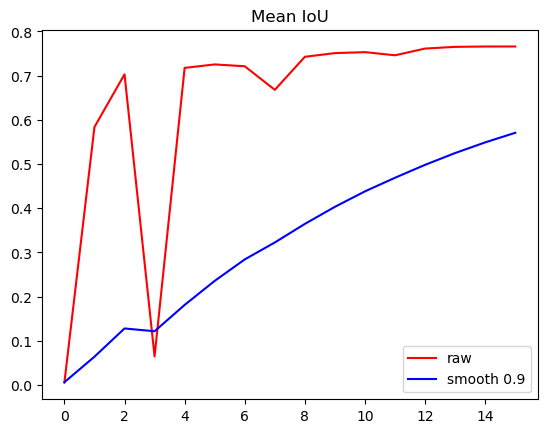

Epoch 3/20, Training Loss: 0.0231, Training Time:   3 hr 18 min 47 sec


Epoch 3:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 4, Batch 1389, Mean IoU: 0.7691 (0.7718), Training Loss: 0.02188783
LR: 0.00047901, Eval time:  2 min 10 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 4, Batch 2778, Mean IoU: 0.7699 (0.7723), Training Loss: 0.02169579
LR: 0.00045749, Eval time:  2 min  7 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 4, Batch 4167, Mean IoU: 0.7691 (0.7722), Training Loss: 0.02152656
LR: 0.00043693, Eval time:  2 min  6 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 4, Batch 5556, Mean IoU: 0.7645 (0.7686), Training Loss: 0.02152882
LR: 0.00041730, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 4, Batch 6945, Mean IoU: 0.7734 (0.7775), Training Loss: 0.02143811
LR: 0.00039855, Eval time:  2 min  7 sec


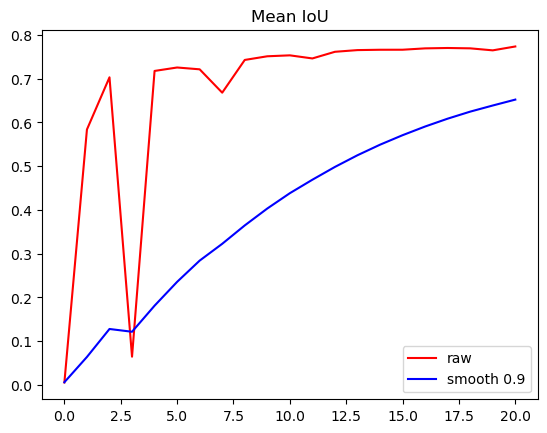

Epoch 4/20, Training Loss: 0.0214, Training Time:   4 hr 25 min 38 sec


Epoch 4:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 5, Batch 1389, Mean IoU: 0.6993 (0.7002), Training Loss: 0.02051016
LR: 0.00038059, Eval time:  2 min 11 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 5, Batch 2778, Mean IoU: 0.7816 (0.7818), Training Loss: 0.02045187
LR: 0.00036349, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 5, Batch 4167, Mean IoU: 0.7818 (0.7830), Training Loss: 0.02035317
LR: 0.00034715, Eval time:  2 min  6 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 5, Batch 5556, Mean IoU: 0.7832 (0.7841), Training Loss: 0.02029157
LR: 0.00033155, Eval time:  2 min 20 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 5, Batch 6945, Mean IoU: 0.7814 (0.7819), Training Loss: 0.02021857
LR: 0.00031665, Eval time:  2 min  9 sec


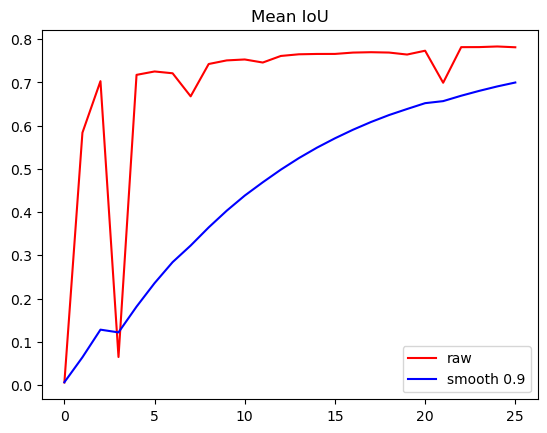

Epoch 5/20, Training Loss: 0.0202, Training Time:   5 hr 35 min 52 sec


Epoch 5:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 6, Batch 1389, Mean IoU: 0.7844 (0.7871), Training Loss: 0.01967927
LR: 0.00030238, Eval time:  2 min 50 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 6, Batch 2778, Mean IoU: 0.7857 (0.7886), Training Loss: 0.01963111
LR: 0.00028880, Eval time:  2 min 37 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 6, Batch 4167, Mean IoU: 0.7839 (0.7868), Training Loss: 0.01960469
LR: 0.00027582, Eval time:  2 min  6 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 6, Batch 5556, Mean IoU: 0.7887 (0.7918), Training Loss: 0.01964135
LR: 0.00026343, Eval time:  2 min  7 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 6, Batch 6945, Mean IoU: 0.7860 (0.7892), Training Loss: 0.01958987
LR: 0.00025159, Eval time:  2 min  6 sec


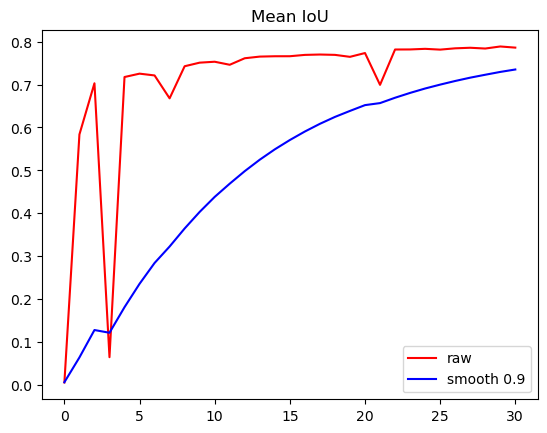

Epoch 6/20, Training Loss: 0.0196, Training Time:   6 hr 47 min 45 sec


Epoch 6:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 7, Batch 1389, Mean IoU: 0.7870 (0.7906), Training Loss: 0.01901890
LR: 0.00024025, Eval time:  2 min 33 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 7, Batch 2778, Mean IoU: 0.7837 (0.7881), Training Loss: 0.01902133
LR: 0.00022946, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 7, Batch 4167, Mean IoU: 0.7807 (0.7840), Training Loss: 0.01906060
LR: 0.00021914, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 7, Batch 5556, Mean IoU: 0.7844 (0.7881), Training Loss: 0.01906711
LR: 0.00020930, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 7, Batch 6945, Mean IoU: 0.7854 (0.7895), Training Loss: 0.01902567
LR: 0.00019989, Eval time:  2 min 14 sec


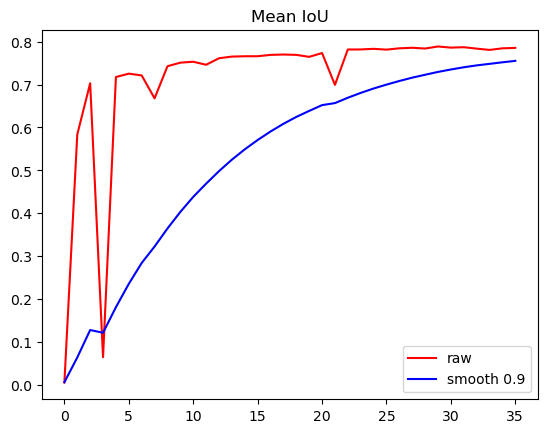

Epoch 7/20, Training Loss: 0.0190, Training Time:   7 hr 56 min 26 sec


Epoch 7:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 8, Batch 1389, Mean IoU: 0.7860 (0.7894), Training Loss: 0.01870365
LR: 0.00019088, Eval time:  2 min 17 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 8, Batch 2778, Mean IoU: 0.7853 (0.7876), Training Loss: 0.01862131
LR: 0.00018231, Eval time:  2 min 10 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 8, Batch 4167, Mean IoU: 0.7856 (0.7891), Training Loss: 0.01866512
LR: 0.00017411, Eval time:  2 min 10 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 8, Batch 5556, Mean IoU: 0.7841 (0.7877), Training Loss: 0.01865119
LR: 0.00016629, Eval time:  2 min 10 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 8, Batch 6945, Mean IoU: 0.7864 (0.7905), Training Loss: 0.01864819
LR: 0.00015882, Eval time:  2 min 50 sec


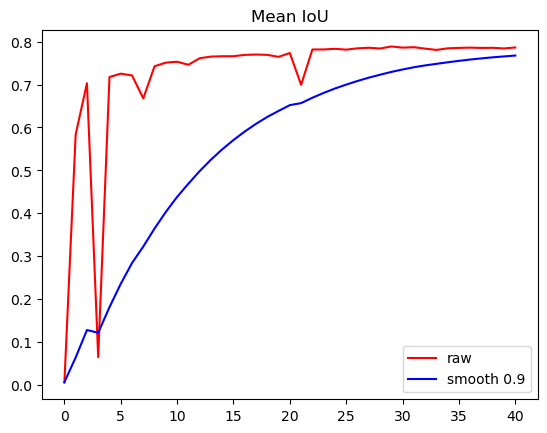

Epoch 8/20, Training Loss: 0.0186, Training Time:   9 hr  7 min 58 sec


Epoch 8:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 9, Batch 1389, Mean IoU: 0.7890 (0.7906), Training Loss: 0.01836412
LR: 0.00015166, Eval time:  2 min 24 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 9, Batch 2778, Mean IoU: 0.7911 (0.7920), Training Loss: 0.01833550
LR: 0.00014485, Eval time:  2 min 13 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 9, Batch 4167, Mean IoU: 0.7849 (0.7863), Training Loss: 0.01834580
LR: 0.00013834, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 9, Batch 5556, Mean IoU: 0.7913 (0.7929), Training Loss: 0.01831236
LR: 0.00013212, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 9, Batch 6945, Mean IoU: 0.7916 (0.7925), Training Loss: 0.01831126
LR: 0.00012618, Eval time:  2 min 11 sec


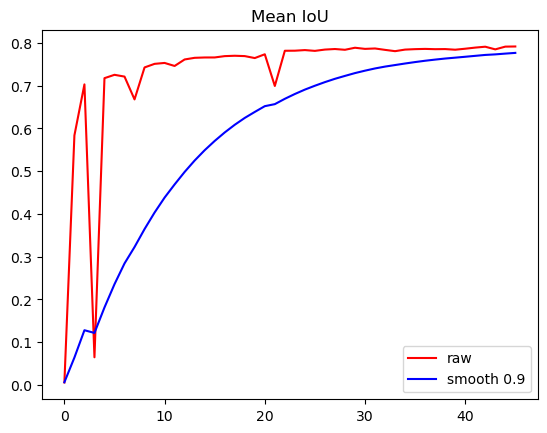

Epoch 9/20, Training Loss: 0.0183, Training Time:  10 hr 18 min 56 sec


Epoch 9:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 10, Batch 1389, Mean IoU: 0.7912 (0.7946), Training Loss: 0.01809406
LR: 0.00012050, Eval time:  2 min 29 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 10, Batch 2778, Mean IoU: 0.7910 (0.7941), Training Loss: 0.01806678
LR: 0.00011508, Eval time:  2 min 13 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 10, Batch 4167, Mean IoU: 0.7868 (0.7910), Training Loss: 0.01806143
LR: 0.00010991, Eval time:  2 min 33 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 10, Batch 5556, Mean IoU: 0.7904 (0.7936), Training Loss: 0.01805368
LR: 0.00010497, Eval time:  2 min  5 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 10, Batch 6945, Mean IoU: 0.7913 (0.7941), Training Loss: 0.01804241
LR: 0.00010026, Eval time:  2 min  5 sec


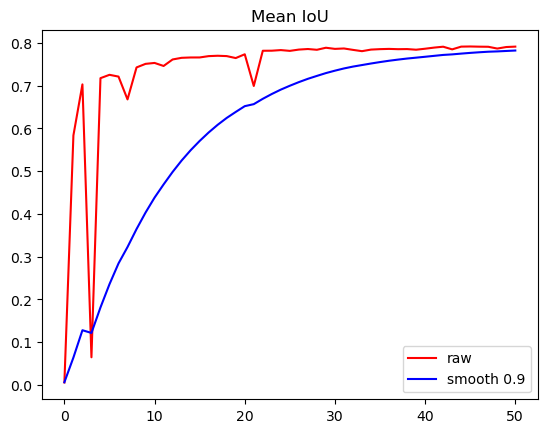

Epoch 10/20, Training Loss: 0.0180, Training Time:  11 hr 34 min 31 sec


Epoch 10:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 11, Batch 1389, Mean IoU: 0.7927 (0.7958), Training Loss: 0.01789143
LR: 0.00010024, Eval time:  2 min 11 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 11, Batch 2778, Mean IoU: 0.7915 (0.7951), Training Loss: 0.01787554
LR: 0.00010024, Eval time:  2 min 10 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 11, Batch 4167, Mean IoU: 0.7896 (0.7930), Training Loss: 0.01787453
LR: 0.00010024, Eval time:  2 min 10 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 11, Batch 5556, Mean IoU: 0.7918 (0.7949), Training Loss: 0.01786213
LR: 0.00010024, Eval time:  2 min 12 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 11, Batch 6945, Mean IoU: 0.7918 (0.7945), Training Loss: 0.01785690
LR: 0.00010024, Eval time:  2 min 21 sec


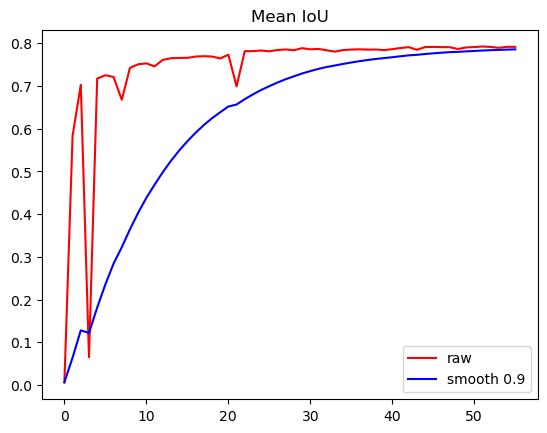

Epoch 11/20, Training Loss: 0.0179, Training Time:  12 hr 44 min  4 sec


Epoch 11:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 12, Batch 1389, Mean IoU: 0.7898 (0.7914), Training Loss: 0.01767727
LR: 0.00010024, Eval time:  4 min 30 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 12, Batch 2778, Mean IoU: 0.7916 (0.7932), Training Loss: 0.01766336
LR: 0.00010024, Eval time:  2 min 22 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 12, Batch 4167, Mean IoU: 0.7924 (0.7950), Training Loss: 0.01770799
LR: 0.00010024, Eval time:  2 min 11 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 12, Batch 5556, Mean IoU: 0.7916 (0.7937), Training Loss: 0.01771835
LR: 0.00010024, Eval time:  2 min 11 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 12, Batch 6945, Mean IoU: 0.7912 (0.7934), Training Loss: 0.01771455
LR: 0.00010024, Eval time:  2 min 11 sec


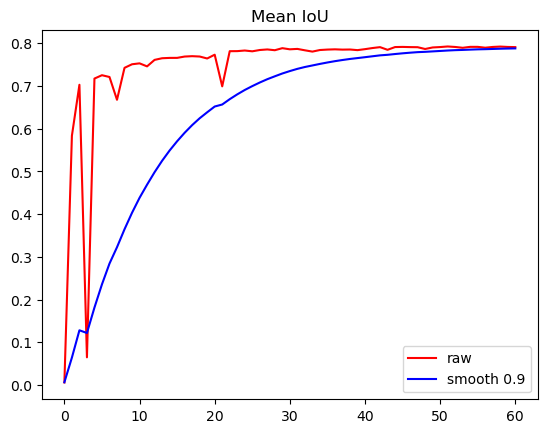

Epoch 12/20, Training Loss: 0.0177, Training Time:  14 hr  1 min  3 sec


Epoch 12:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 13, Batch 1389, Mean IoU: 0.7938 (0.7970), Training Loss: 0.01760823
LR: 0.00010024, Eval time:  2 min 48 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 13, Batch 2778, Mean IoU: 0.7966 (0.7981), Training Loss: 0.01757211
LR: 0.00010024, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 13, Batch 4167, Mean IoU: 0.7939 (0.7963), Training Loss: 0.01758386
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 13, Batch 5556, Mean IoU: 0.7947 (0.7971), Training Loss: 0.01758964
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 13, Batch 6945, Mean IoU: 0.7956 (0.7973), Training Loss: 0.01758151
LR: 0.00010024, Eval time:  2 min  8 sec


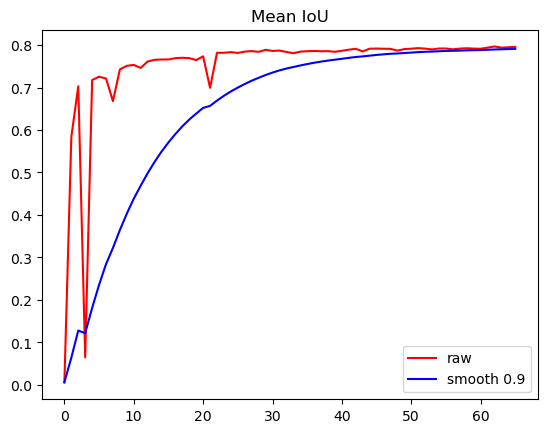

Epoch 13/20, Training Loss: 0.0176, Training Time:  15 hr 14 min  6 sec


Epoch 13:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 14, Batch 1389, Mean IoU: 0.7923 (0.7959), Training Loss: 0.01745607
LR: 0.00010024, Eval time:  2 min 14 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 14, Batch 2778, Mean IoU: 0.7898 (0.7935), Training Loss: 0.01746482
LR: 0.00010024, Eval time:  2 min 16 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 14, Batch 4167, Mean IoU: 0.7859 (0.7900), Training Loss: 0.01746401
LR: 0.00010024, Eval time:  2 min 10 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 14, Batch 5556, Mean IoU: 0.7910 (0.7937), Training Loss: 0.01748347
LR: 0.00010024, Eval time:  2 min 11 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 14, Batch 6945, Mean IoU: 0.7844 (0.7874), Training Loss: 0.01747789
LR: 0.00010024, Eval time:  2 min 11 sec


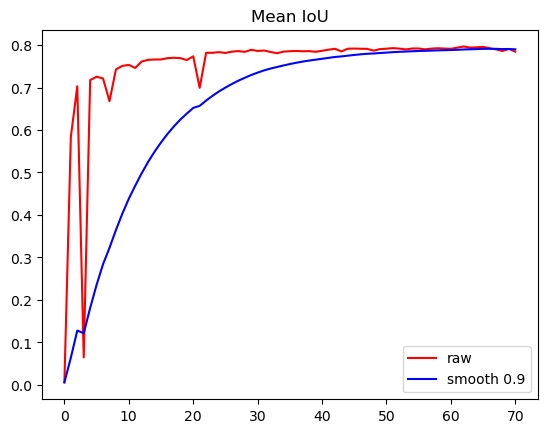

Epoch 14/20, Training Loss: 0.0175, Training Time:  16 hr 23 min 29 sec


Epoch 14:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 15, Batch 1389, Mean IoU: 0.7935 (0.7973), Training Loss: 0.01736171
LR: 0.00010024, Eval time:  2 min 51 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 15, Batch 2778, Mean IoU: 0.7960 (0.7990), Training Loss: 0.01739960
LR: 0.00010024, Eval time:  2 min 11 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 15, Batch 4167, Mean IoU: 0.7954 (0.7983), Training Loss: 0.01737385
LR: 0.00010024, Eval time:  2 min  9 sec
Unable to upload images for epoch Epoch 15, Batch 4167, Mean IoU: 0.7954 (0.7983), Training Loss: 0.01737385
LR: 0.00010024, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 15, Batch 5556, Mean IoU: 0.7911 (0.7940), Training Loss: 0.01736725
LR: 0.00010024, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 15, Batch 6945, Mean IoU: 0.7950 (0.7981), Training Loss: 0.01735086
LR: 0.00010024, Eval time:  2 min 11 sec


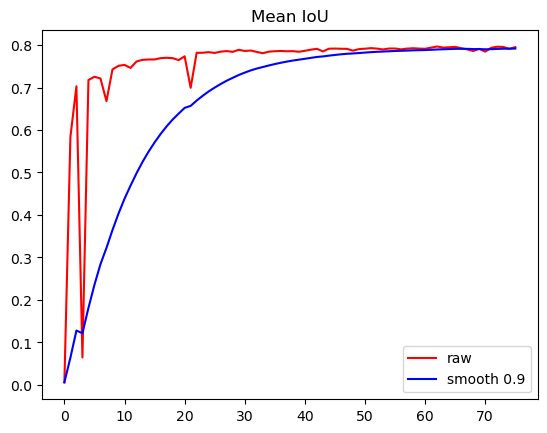

Epoch 15/20, Training Loss: 0.0174, Training Time:  17 hr 34 min 57 sec


Epoch 15:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 16, Batch 1389, Mean IoU: 0.7995 (0.8024), Training Loss: 0.01724707
LR: 0.00010024, Eval time:  2 min 24 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 16, Batch 2778, Mean IoU: 0.7995 (0.8021), Training Loss: 0.01725014
LR: 0.00010024, Eval time:  2 min  6 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 16, Batch 4167, Mean IoU: 0.7979 (0.8002), Training Loss: 0.01724904
LR: 0.00010024, Eval time:  2 min  5 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 16, Batch 5556, Mean IoU: 0.7972 (0.8008), Training Loss: 0.01725142
LR: 0.00010024, Eval time:  2 min  5 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 16, Batch 6945, Mean IoU: 0.7971 (0.7995), Training Loss: 0.01726331
LR: 0.00010024, Eval time:  2 min  5 sec


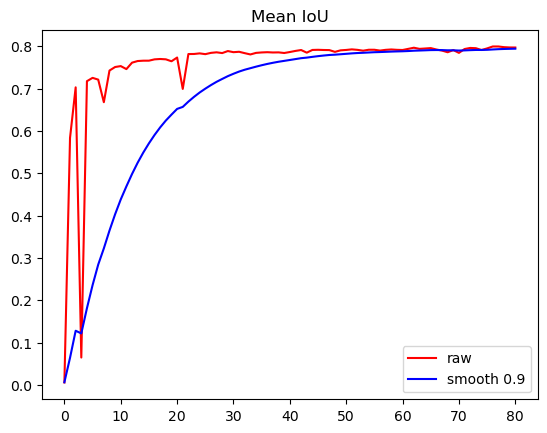

Epoch 16/20, Training Loss: 0.0173, Training Time:  18 hr 42 min 50 sec


Epoch 16:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 17, Batch 1389, Mean IoU: 0.7950 (0.8000), Training Loss: 0.01705935
LR: 0.00010024, Eval time:  2 min  6 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 17, Batch 2778, Mean IoU: 0.7968 (0.8008), Training Loss: 0.01711378
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 17, Batch 4167, Mean IoU: 0.7973 (0.8013), Training Loss: 0.01714966
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 17, Batch 5556, Mean IoU: 0.7967 (0.8012), Training Loss: 0.01715445
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 17, Batch 6945, Mean IoU: 0.7962 (0.8013), Training Loss: 0.01717370
LR: 0.00010024, Eval time:  2 min  8 sec


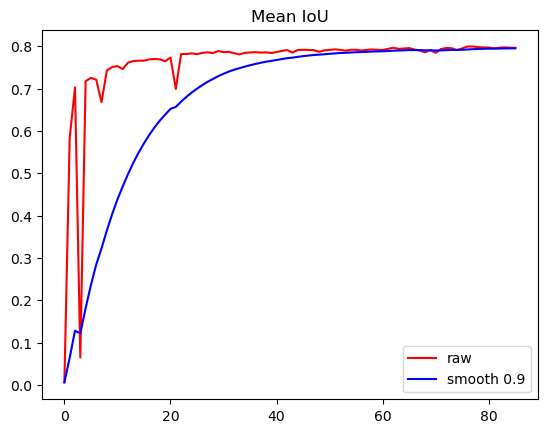

Epoch 17/20, Training Loss: 0.0172, Training Time:  19 hr 48 min  8 sec


Epoch 17:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 18, Batch 1389, Mean IoU: 0.7986 (0.8014), Training Loss: 0.01705798
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 18, Batch 2778, Mean IoU: 0.7933 (0.7968), Training Loss: 0.01703332
LR: 0.00010024, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 18, Batch 4167, Mean IoU: 0.7993 (0.8025), Training Loss: 0.01704345
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 18, Batch 5556, Mean IoU: 0.7987 (0.8021), Training Loss: 0.01707073
LR: 0.00010024, Eval time:  2 min  9 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 18, Batch 6945, Mean IoU: 0.7976 (0.7999), Training Loss: 0.01713155
LR: 0.00010024, Eval time:  2 min  8 sec


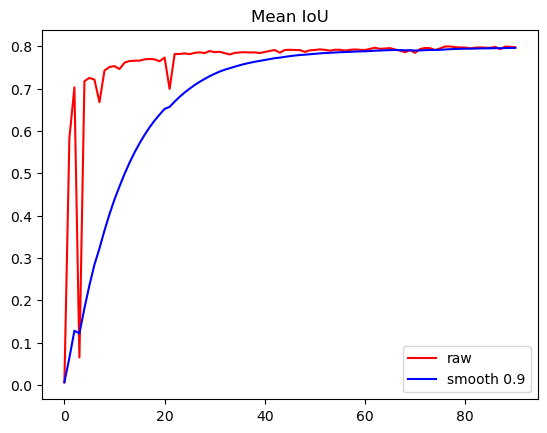

Epoch 18/20, Training Loss: 0.0171, Training Time:  20 hr 53 min 13 sec


Epoch 18:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 19, Batch 1389, Mean IoU: 0.8005 (0.8031), Training Loss: 0.01695745
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 19, Batch 2778, Mean IoU: 0.8000 (0.8019), Training Loss: 0.01696069
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 19, Batch 4167, Mean IoU: 0.7998 (0.8020), Training Loss: 0.01696365
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 19, Batch 5556, Mean IoU: 0.7990 (0.8018), Training Loss: 0.01697496
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 19, Batch 6945, Mean IoU: 0.8003 (0.8025), Training Loss: 0.01699561
LR: 0.00010024, Eval time:  2 min  8 sec


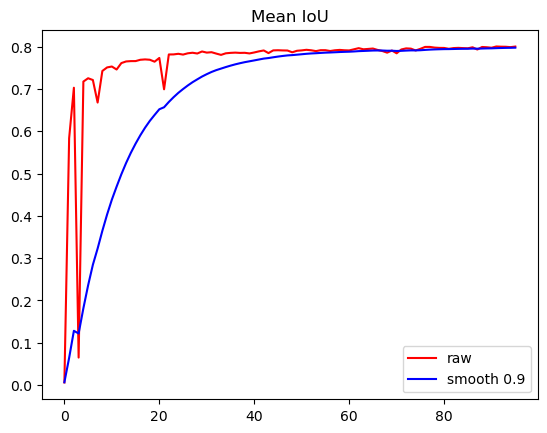

Epoch 19/20, Training Loss: 0.0170, Training Time:  21 hr 58 min  3 sec


Epoch 19:   0%|          | 0/6949 [00:00<?, ?it/s]

Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 20, Batch 1389, Mean IoU: 0.7999 (0.8028), Training Loss: 0.01700251
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 20, Batch 2778, Mean IoU: 0.7977 (0.8003), Training Loss: 0.01695324
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 20, Batch 4167, Mean IoU: 0.7954 (0.7980), Training Loss: 0.01695741
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 20, Batch 5556, Mean IoU: 0.7995 (0.8028), Training Loss: 0.01694233
LR: 0.00010024, Eval time:  2 min  8 sec


Eval:   0%|          | 0/773 [00:00<?, ?it/s]

Epoch 20, Batch 6945, Mean IoU: 0.7959 (0.7992), Training Loss: 0.01695618
LR: 0.00010024, Eval time:  2 min  8 sec


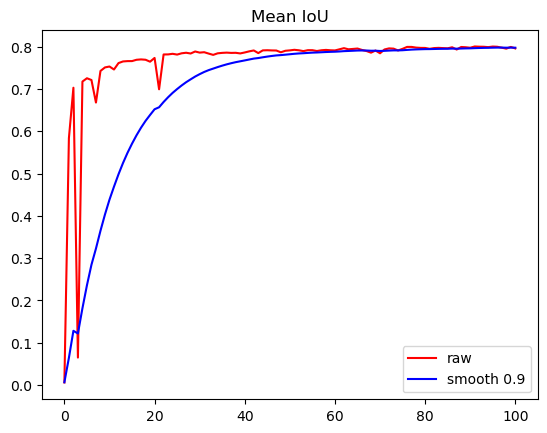

Epoch 20/20, Training Loss: 0.0170, Training Time:  23 hr  2 min 53 sec
Training complete.


In [13]:
miou = []
batch_loss = []
timestep = []
epoch_loss = []
get_lr = scheduler.get_last_lr if scheduler else lambda : [lr_start]
train_start_time = time()
for epoch in range(num_epochs):
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    if epoch == 0:
        iou_scores = []
        with torch.no_grad():
            for test_images, test_masks in tqdm(test_loader, desc="Eval", leave=False, miniters=tqdm_miniters * 2):
                test_outputs = model(test_images)['out']
                iou = calculate_iou(test_outputs, test_masks, num_classes=13)
                iou_scores.append(iou)
        mean_iou = np.mean(iou_scores)
        miou.append(mean_iou)
        print(f"Initial MIoU: {mean_iou:.4f}")

    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}", miniters=tqdm_miniters)
    model.train()
    running_loss = 0.0
    batch_count = 0

    for images, masks in train_loader:
        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()
        if scheduler and epoch < num_steps_end_decay:
            scheduler.step()

        running_loss += loss.item() * images.size(0)
        batch_count += 1
        pbar.update()

        if batch_count % eval_frequency == 0:
            model.eval()
            t = time()
            iou_scores = []
            
            with torch.no_grad():
                for test_images, test_masks in tqdm(test_loader, desc="Eval", leave=False, miniters=tqdm_miniters * 2):
                    test_outputs = model(test_images)['out']
                    iou = calculate_iou(test_outputs, test_masks, num_classes=13)
                    iou_scores.append(iou)

            mean_iou = np.mean(iou_scores)
            curr_time = time()
            eval_time = round(curr_time - t)
            t_loss = running_loss / (batch_count * batch_size)

            batch_loss.append(t_loss)
            miou.append(mean_iou)
            timestep.append([epoch, batch_count, round(curr_time - train_start_time)])

            msg = f"Epoch {epoch+1}, Batch {batch_count}, Mean IoU: {mean_iou:.4f} ({np.median(iou_scores):.4f}), Training Loss: {t_loss:.8f}\nLR: {get_lr()[0]:.8f}, Eval time: {eval_time // 60:2d} min {eval_time % 60:2d} sec"
            # webhook.send_msg(msg)
            print(msg, flush=True)
            
            model.train()
    
            plt.clf()
            plt.plot(miou, 'r', label="raw")
            plt.plot(smooth(miou, 0.9), 'b', label="smooth 0.9")
            plt.legend()
            plt.title("Mean IoU")
            # plt.ylim(0, 1)
            plt.savefig(f"{webhook.path}/current.png")
            webhook.send_img(msg)

    pbar.close()
    plt.show()
    current_state = {
        "optimizer" : optimizer.state_dict(),
        "scheduler" : scheduler.state_dict() if scheduler else None,
        "model"     : model.state_dict()
    }
    torch.save(current_state, f"semantic_segmentation/ss_mobilenet_{epoch:02d}.pt")
    np.savez("semantic_segmentation/SS_Results.npz", 
             miou=np.array(miou), 
             batch_loss=np.array(batch_loss), 
             epoch_loss=np.array(epoch_loss), 
             timestep=np.array(timestep, dtype=np.uint64))
    e_loss = running_loss / train_size
    epoch_loss.append([e_loss, running_loss])
    train_time = round(time() - train_start_time)
    hr = train_time // 3600
    train_time %= 3600
    msg = f"Epoch {epoch+1}/{num_epochs}, Training Loss: {e_loss:.4f}, Training Time: {hr:3d} hr {train_time // 60:2d} min {train_time % 60:2d} sec"
    webhook.send_msg(msg)
    print(msg, flush=True)
    sleep(10)

print('Training complete.')